# Probabilistic Programming and the Bechdel Test

First, we'll need libraries. They're all quite standard for data analysis with python, except for pymc3, which is a probabilistic programming package.

_Probabilistic Programming_ how you turn stochastic models into something a computer can understand. With pymc3, we can define stochastic models, and then get estimates for their distributions (or rather, the parameters of their distributions) using cutting-edge Monte Carlo Markov Chain methods. 

In [1]:
# computational libraries
# - pandas: working with tabular data
# - numpy: vector math
# - pymc3: probabilistic programming package
# - scipy: general scientific computing library
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy.stats as stats

# plotting libraries
# - matplotlib: base plotting library
# - seaborn: nice statistical plots, based on matplotplib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_context("talk")

/Users/trainorpj/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Next, we'll load in the data and fix it up a bit using pandas. The code below processes our data for futher analysis.

In [2]:
mov = (
    # load data from csv
    pd.read_csv('bechdel/movies.csv')
    # keep movies after 1990
    .query("year > 1990")
    # remove year-of-release dollar-amounts
    .drop(columns=['budget', 'domgross', 'intgross', 'code'])
    # rename 2013-dollars to simpler names
    .rename(columns={
        "binary": "bechdel_result",
        "budget_2013$": "budget",
        "domgross_2013$": "domgross",
        "intgross_2013$": "intgross"
    })
)

# calculate profit
mov = mov.assign(
        profit = mov["intgross"] - mov["budget"])

# calculate logs of budget, grossing, and profit
# note: profits can be negative, so take the absolute value,
# and have an indicator for 'made_money'
mov = mov.assign(
        log_budget = np.log(mov["budget"]),
        log_domgross = np.log(mov["domgross"]),
        log_intgross = np.log(mov["intgross"]),
        log_abs_profit = np.log(np.abs(mov["profit"])),
        made_money = mov["profit"] > 0)

## Budget

Consider the budgets of films that passed and failed the Bechdel Test.

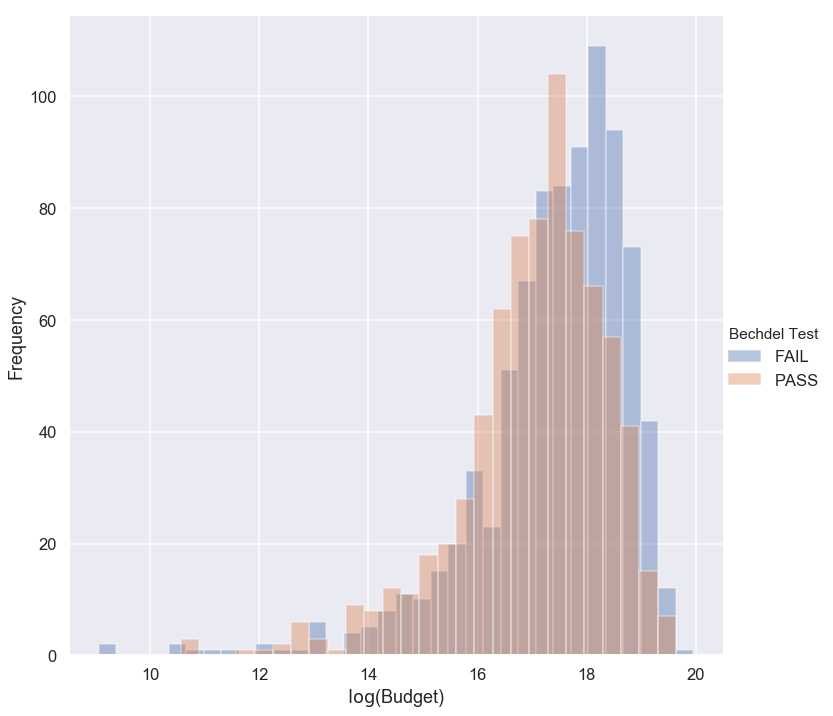

In [3]:
# plot buget distribution for movies that pass and fail the test
g = sns.FacetGrid(mov, hue='bechdel_result', height=10)
g.map(sns.distplot, "log_budget", kde=False)
g.set_titles("Distribution of Budgets")
g.set_xlabels("$\log$(Budget)"); g.set_ylabels("Frequency")
g.add_legend(title="Bechdel Test");

We might ask:

> Are the budgets for films that passed the Bechdel Test different from those that did not?

This could be answered with a hypothesis test... and that's what the authors of the 538 article did. However, with probabilistic programming, we have more powerful inference tools at our disposal.

For example, suppose that $B_0$ is a random variable representing the budget for a film that _fails_ the Bechdel Test, and suppose that $B_0 \sim LogNormal(\mu_0, \sigma_0)$, where $\mu_0$ and $\sigma_0$ are unknown. If we do the same for the budgets that _pass_ the Bechdel Test, $B_1$, then we have

$$B_i \sim LogNormal(\mu_i, \sigma_i^2) \text{  } i=0, 1$$

We can use MCMC methods to get values for $\mu_i$ and $\sigma_i$. Assume the have a half-normal distribution, meaning we know very little about them. Then our full model is:

\begin{align*}
\mu_i &\sim HalfNormal(10) \\
\sigma_i &\sim HalfNormal(10) \\
B_i &\sim LogNormal(\mu_i, \sigma_i) \\
i &= 0, 1
\end{align*}

The code below shows how to set this up in pymc3.

> **Note**: pymc3 utilizes a tensor library called Theano. Therefore, any pymc variable is a Theano tensor, _not_ a numpy array. The distinction probably won't be important for this topic, but it's worth noting.

In [4]:
# indices for films that passed
_bechdel_pass_mask = mov['bechdel_result'] == 'PASS'

# get data for passing/failing movies
passing_movies = mov.loc[_bechdel_pass_mask]
failing_movies = mov.loc[~_bechdel_pass_mask]

# construct the model
with pm.Model() as budget_model:
    # construct paramters
    # this is what we're doing inference on. Note that shape=2,
    # which corresponds to the two cases
    μ = pm.HalfNormal('μ', sd=10, shape=2)
    σ = pm.HalfNormal('σ', sd=10, shape=2)
    
    # here, we're incorporating the actual data
    budget_fail = pm.Lognormal('budget_fail', 
                               mu=μ[0], sd=σ[0], 
                               observed=failing_movies["budget"])
    budget_pass = pm.Lognormal('budget_pass', 
                               mu=μ[1], sd=σ[1], 
                               observed=passing_movies["budget"])

We've set up the model, but haven't done any inference!

The next step uses MCMC methods to search the space for the parameters. This step may take a few minutes!

This produces a "trace," which is just the samples that were taken (along with a few other goodies). This is the most important piece of data, so cherish it! You might want to save it off so that you don't have to run the model again. 

The traceplot shows the frequency of the trace values on the left, i.e. the posterior distribution, and the actual sample paths on the right. We see that the $mu_i$'s are distinct. That provides some evidence that the means of the distributions are different... like a hypothesis test!

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:13<00:00, 1444.88draws/s]


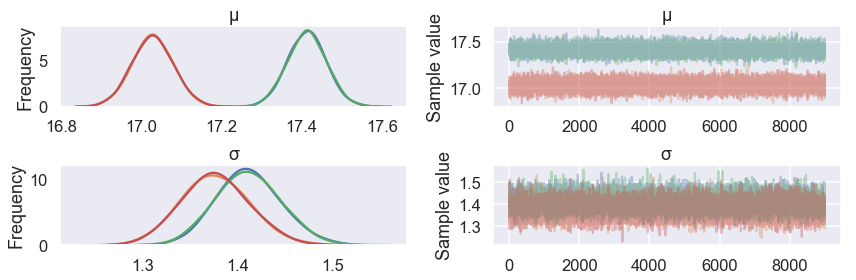

In [5]:
with budget_model:
    budget_trace = pm.sample(9000, tune=1000)
    
pm.traceplot(budget_trace);

We can go one step further, and calculate the Credible Interval/Highest-Posterior Density (HPD)...

What's the HPD?

When considering the posterior distribution (i.e. distribution of the trace), the HPD is an interval that contains 95% of the density of that distribution. Please note a few things:

- the HPD is not always the same... for any distribution there are many choices of HPD
- this is **not** a confidence interval. In fact, I'd argue that it's _better_ than a confidence interval, since it gives us an actual uncertainty
- you can interpret the 95%-HPD as like so: given the prior distribution and the observed data, it is 95% likely that the true parameter is contained in the HPD

But now you might ask what our choice of parameter should be. A good choice is the mode, since that's where most of the mass of the posterior lies. Whatever our choice, we should always report the HPD with it.

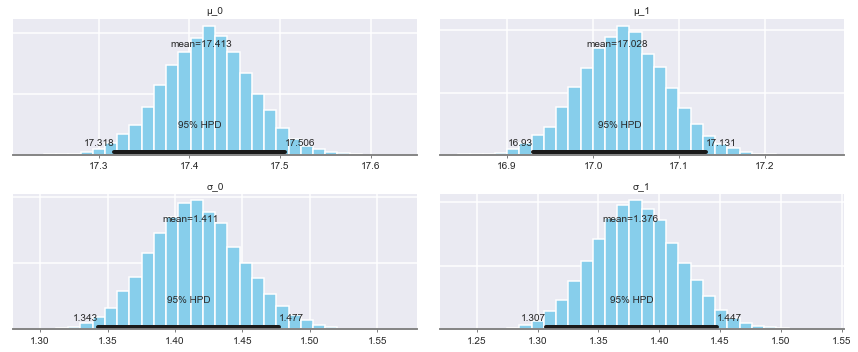

In [6]:
pm.plot_posterior(budget_trace);

## Grossing

The next block of code is lengthy, but necessary for doing repeated analysis. Feel free to skip it if you want to get straight to the inference.

In [7]:
class CompareBechdelLogNormal():
    def __init__(self, data, continuous_var, bechdel_var="bechdel_result"):
        """helper class for building and fitting Binary LogNormal distributions
        
        Parameters
        ----------
        data : pandas DataFrame
        
        continuous_var : str
            name of log-normal variable in pandas dataframe. Do not apply np.log to 
            this variable
        
        binary_var: str
            name of binary classifier for log-normal variable. This will split the
            dataset in two
        """
        
        # store variable names
        self.var_names = dict(continuous=continuous_var,
                              bechdel=bechdel_var)
        
        data = data[[continuous_var, bechdel_var]]
        
        if data[continuous_var].hasnans:
            print("dropping nans")
            data = data.dropna()
        
        # create mask to select variables
        bechdel_pass_mask = data[bechdel_var] == "PASS"
        
        observed_pass = data.loc[bechdel_pass_mask][continuous_var]
        observed_fail = data.loc[~bechdel_pass_mask][continuous_var]
        
        # construct pymc3 model
        with pm.Model() as self.model:
            # parameters for LogNormal distribution
            mu = pm.HalfNormal('mu', sd=10, shape=2)
            sd = pm.HalfNormal('sd', sd=10, shape=2)
            
            # target LogNormal distributions
            rv_fail = pm.Lognormal('rv_fail', 
                                   mu=mu[0], sd=sd[0], 
                                   observed=observed_fail)
            rv_pass = pm.Lognormal('rv_pass', 
                                   mu=mu[1], sd=sd[1], 
                                   observed=observed_pass)
        
        # instantiate inference results
        self.trace = None
        self.mu_ = None
        self.sd_ = None
        self.hpds_ = None        
            
    def fit(self, n_sample, **kwargs):
        # sample trace
        with self.model:
            self.trace = pm.sample(n_sample, **kwargs)
        
        # trace summary is a dataframe that contains information
        # about the trace
        summary = pm.summary(self.trace)
        
        # set mu and sd
        # note: these are 1x2 arrays, for each distribution
        self.mu_ = summary['mean'][['mu__0', 'mu__1']].values
        self.sd_ = summary['sd'][['sd__0', 'sd__1']].values
        
        # save HPDs. This is a dataframe
        self.hpds_ = summary[["hpd_2.5", "hpd_97.5"]]
        
        
            
    def plot_trace(self, *args, **kwargs):
        if self.trace is not None:
            pm.traceplot(self.trace, *args, **kwargs)
            
    def plot_posterior(self, *args, **kwargs):
        if self.trace is not None:
            pm.plot_posterior(self.trace, *args, **kwargs)
    
    def plot_hpd(self, *args, **kwargs):
        if self.trace is not None:
            pm.forestplot(self.trace, *args, **kwargs)

Now, we can easily construct a model to compare the domestic grossing of movies that pass or fail the bechdel test.

dropping nans


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1240.47draws/s]


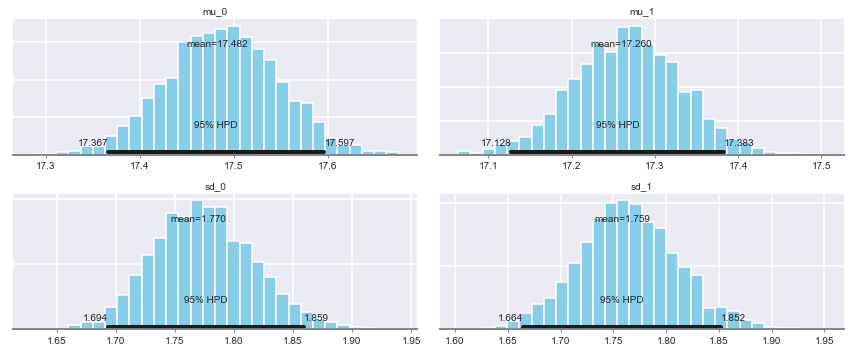

In [8]:
# construct model
domgross_model = CompareBechdelLogNormal(mov, 'domgross')

# fit model
domgross_model.fit(2000)

# plot results
domgross_model.plot_posterior()

We once again see a significant difference in the means (i.e. their HPDs do not overlap). Note that movies that passed the Bechdel test made less money than those that failed it.

# So what's the big idea?

This is a _much_ stronger tool than hypothesis testing, and in my opinion, it's easier to interpret. Now we can say the distributions are different, _and_ provide a degree of uncertainty. We can make these assertions for all the data provided. 

The continuous variables are:

- budget
- international grossing
- profit (related to the above)

We have two categorical variables, as well:

- passed Bechdel Test
- made a profit (earnings > budget)

With this framework we can answer any question of the form:

> Did movies that passed the Bechdel Test <cost more/make more/profit more> than movies that did not?

We can also ask questions like:

> Given a movie made $D$ dollars, what is the probability that it passed the Bechdel Test?

Or

> If a movie made a profit, what is the likelihood that it passed the Bechdel Test?